In [1]:
from __future__ import annotations

from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import os
import typing as tp
from core import utils
import typing as tp
import math
import itertools as it
from typing_extensions import Annotated
from PIL import Image, ImageOps
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from core import utils

In [8]:
def plot_image(image_arr, shape, title=''):
    plt.imshow(image_arr.reshape(shape), cmap="gray")
    plt.title(shape)
    plt.xticks(())
    plt.yticks(())

def plot_portraits(images, shape, n_row, n_col, titles=None):
    titles = ['']*n_row*n_col if titles is None else titles
    plt.figure(figsize=(2.2 * n_col, 2.2 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.20)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plot_image(images[i], shape, titles[i])

    plt.show()


def gen_images(
    files: tp.Iterable[utils.AnnotatedImage],
    output_shape=(64, 64),
    gray=True,
    crop=True,
) -> tp.Iterable[Image.Image]:
    for file in files:
        image = Image.open(file.image)

        if gray:
            image = ImageOps.grayscale(image)

        if crop:
            min_pt, max_pt = utils.Point.to_min_max(file.points)
            image = image.crop((min_pt.x, min_pt.y, max_pt.x, max_pt.y))

        if output_shape:
            image = image.resize(output_shape)

        yield image

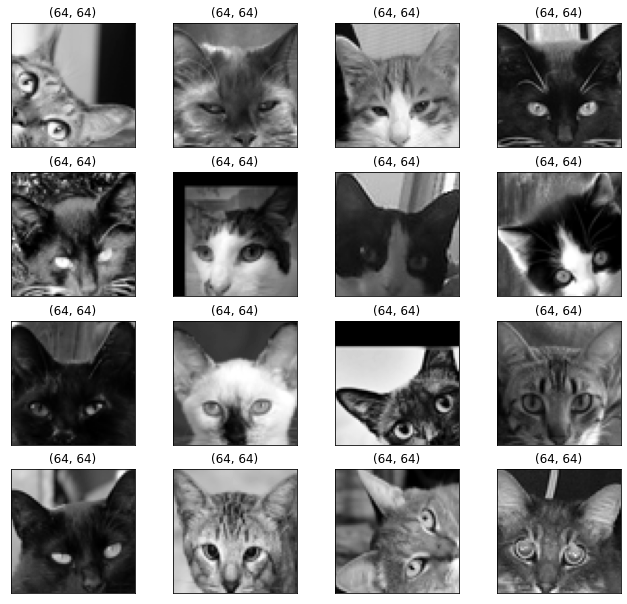

In [12]:
N_SAMPLES = 10_000
files = list(utils.Paths.gen_files())
images = list(gen_images(files[:N_SAMPLES]))
names = [f.image.stem for f in files[:N_SAMPLES]]
shape = np.array(images[0]).shape

X_train = np.array([np.array(im).flatten() for im in images])
plot_portraits(X_train, shape, 4, 4)

<AxesSubplot:>

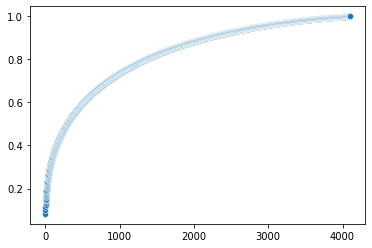

In [13]:
X_mean = X_train.mean(axis=0)
U, S, Vt = np.linalg.svd(X_train, full_matrices=False)
sns.scatterplot(
    x=range(1, len(S) + 1), y=S.cumsum() / S.sum()
)

In [15]:
def reconstruct_with_components(image: int | slice, component: int | slice):
    principle_compoents = U[image, component] * S[component]
    principle_directions = Vt[component]

    return (principle_compoents @ principle_directions) + X_mean

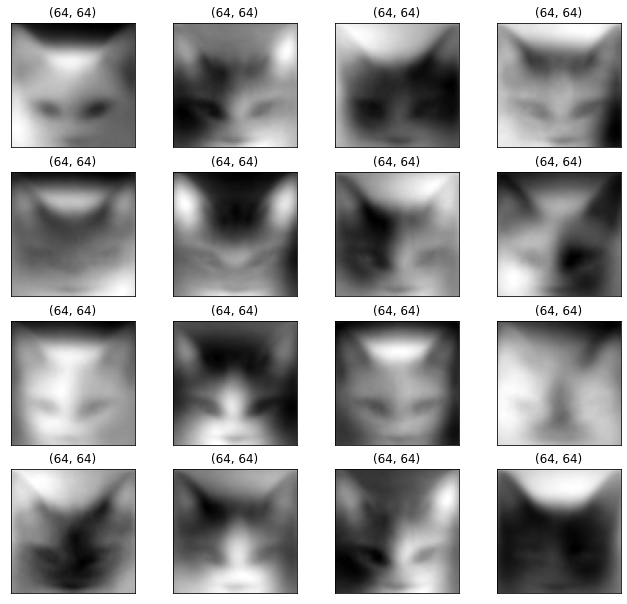

In [21]:
X_final = reconstruct_with_components(slice(10, 30), slice(10))
plot_portraits(X_final, shape, 4 ,4 )

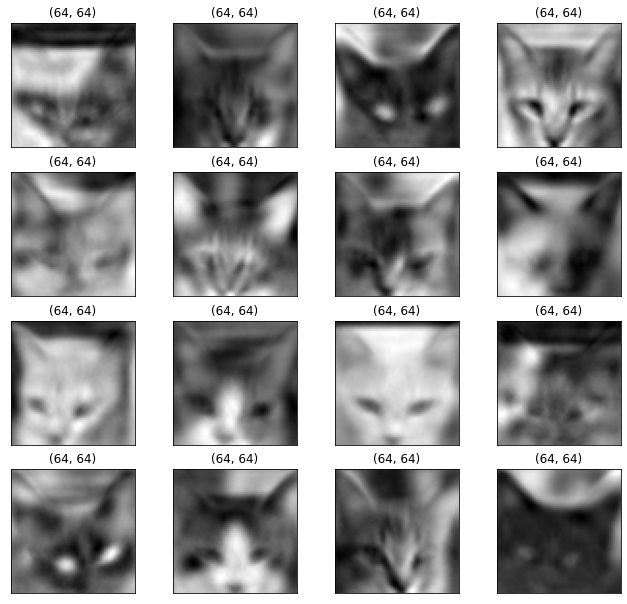

In [19]:
X_final = reconstruct_with_components(slice(10, 30), slice(100))
plot_portraits(X_final, shape, 4 ,4 )

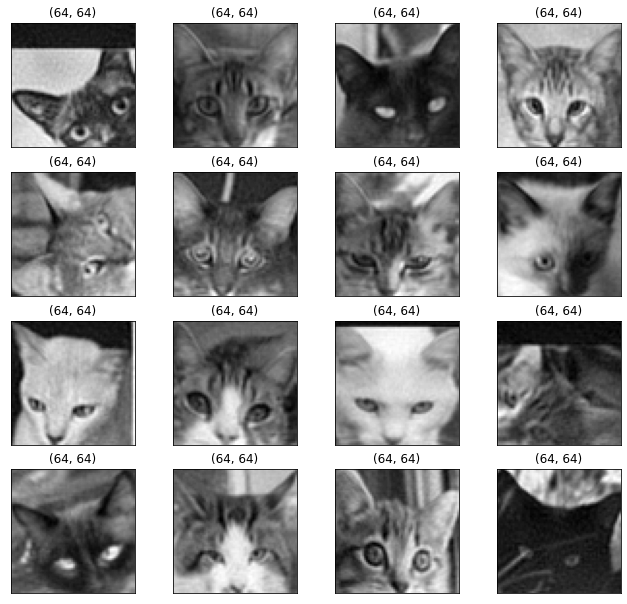

In [20]:
X_final = reconstruct_with_components(slice(10, 30), slice(1000))
plot_portraits(X_final, shape, 4 ,4 )

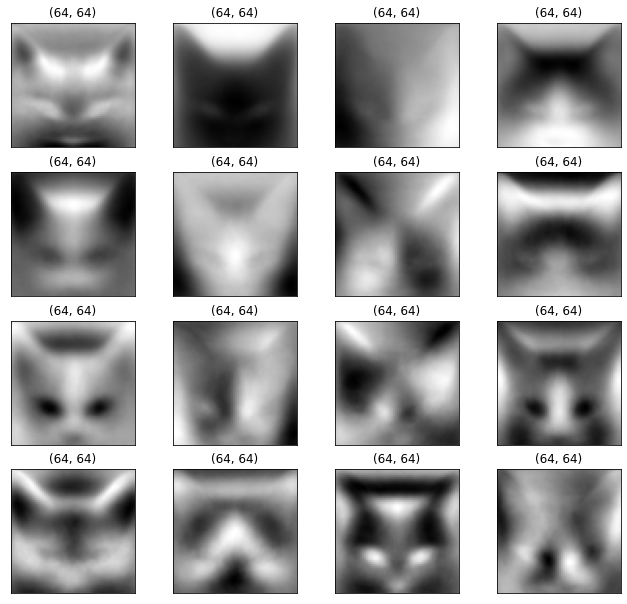

In [23]:
def dilate_components(arr: np.ndarray) -> np.ndarray:
    ret = arr.copy()
    ret = ret - ret.min()
    ret = ret / ret.max()
    return ret

eigenfaces = np.array([dilate_components(arr) for arr in Vt])
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_portraits(eigenfaces, shape, 4, 4, eigenface_titles)